In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from abc import ABC, abstractmethod
from fractions import Fraction
from matplotlib.colors import LogNorm
from scipy.integrate import solve_ivp
from scipy import fftpack
from sklearn.metrics import mean_squared_error

In [181]:
class EpidemiologyModel(ABC):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        self.initial_conditions = initial_conditions
        self.parameters = parameters
        self.t = t
        self.title = 'Epidemiology Model'
        
        if steps is None:
            self.t_eval = np.arange(0, t)
        else:
            self.t_eval = np.linspace(0, t, steps)

    def solve(self, equations):
        sol = solve_ivp(
            equations,
            [0, self.t],
            y0=list(self.initial_conditions.values()),
            args=self.parameters,
            t_eval=self.t_eval,
            dense_output=True
        )        
        return sol.sol(self.t_eval)
    
    def time_plot(self, data, labels, axis_labels, size=(20, 6)):
        width, height = size
        fig, ax = plt.subplots(figsize=(width, height))

        t_span = np.arange(0, self.t)

        for label, values in zip(labels, data):
            ax.plot(t_span, values, label=label)

        x_label, y_label = axis_labels
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend()
        ax.grid()

        return fig, ax
    
    def phase_plot(self, size=(20, 6)):
        width, height = size
        fig, ax = plt.subplots(figsize=(width, height))

        init_condition_S = []
        end_condition_S = []
        init_condition_I = []
        end_condition_I = []
        
        for init_I in np.linspace(0, 1, 11):
            self.initial_conditions["I"] = init_I
            self.initial_conditions["S"] = 1 - sum(value for key, value in self.initial_conditions.items() if key != "S")
            sol_phase = self.solve(self.equations)

            ax.plot(sol_phase[0], sol_phase[1])
            init_condition_S.append(sol_phase[0][0])
            end_condition_S.append(sol_phase[0][-1])
            init_condition_I.append(sol_phase[1][0])
            end_condition_I.append(sol_phase[1][-1])
        
        ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o')
        ax.plot(end_condition_S, end_condition_I, 'k--', color='black', marker='o')
        ax.set_xlabel("Infected (I)")
        ax.set_ylabel("Susceptible (S)")
        ax.legend()
        ax.grid()

        return fig, ax
    
    def fourier(self, data, label, colour, x_max=0.4, size=(20, 6)):
        width, height = size
        fig, ax = plt.subplots(figsize=(width, height))

        fourier = fftpack.fft(data)
        freqs = fftpack.fftfreq(len(data))

        freqs, fourier = zip(*sorted(zip(freqs, fourier)))
        i_min = freqs.index(0)
        i_max = freqs.index(x_max)

        ax.plot(freqs[i_min:i_max], np.abs(np.real(fourier))[i_min:i_max], label=f'{label}', color=colour)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Fourier Transform of {label}')
        ax.grid(True)
        ax.legend(loc='upper right')

    @abstractmethod
    def equations(self, t, init_y):
        pass

    @abstractmethod
    def R0(self):
        pass

--------------
# Problem 1: Numerical integration of the SIR model

In [182]:
class SIR(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta, gamma):
        S, I, R = init_y
        dSdt = -beta * S * I
        dIdt = beta * S * I - gamma * I
        dRdt = gamma * I
        return [dSdt, dIdt, dRdt]

    def R0(self):
        beta, gamma = self.parameters
        return round(beta / gamma, 2) if gamma != 0 else 0

$$
\begin{align}
\frac{dS}{dt} &= -\beta S I, \\
\frac{dI}{dt} &= \beta S I - \gamma I, \\
\frac{dR}{dt} &= \gamma I,
\end{align}
$$

## 1.1. Numerically integrate the ODEs to show two scenarios

/tmp/ipykernel_7285/3724248486.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_7285/2900810982.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o')
/tmp/ipykernel_7285/2900810982.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(end_condition_S, end_condition_I, 'k--', color='black', marker='o')
/tmp/ipykernel_7285/2900810982.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_7285/3724248486.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot 

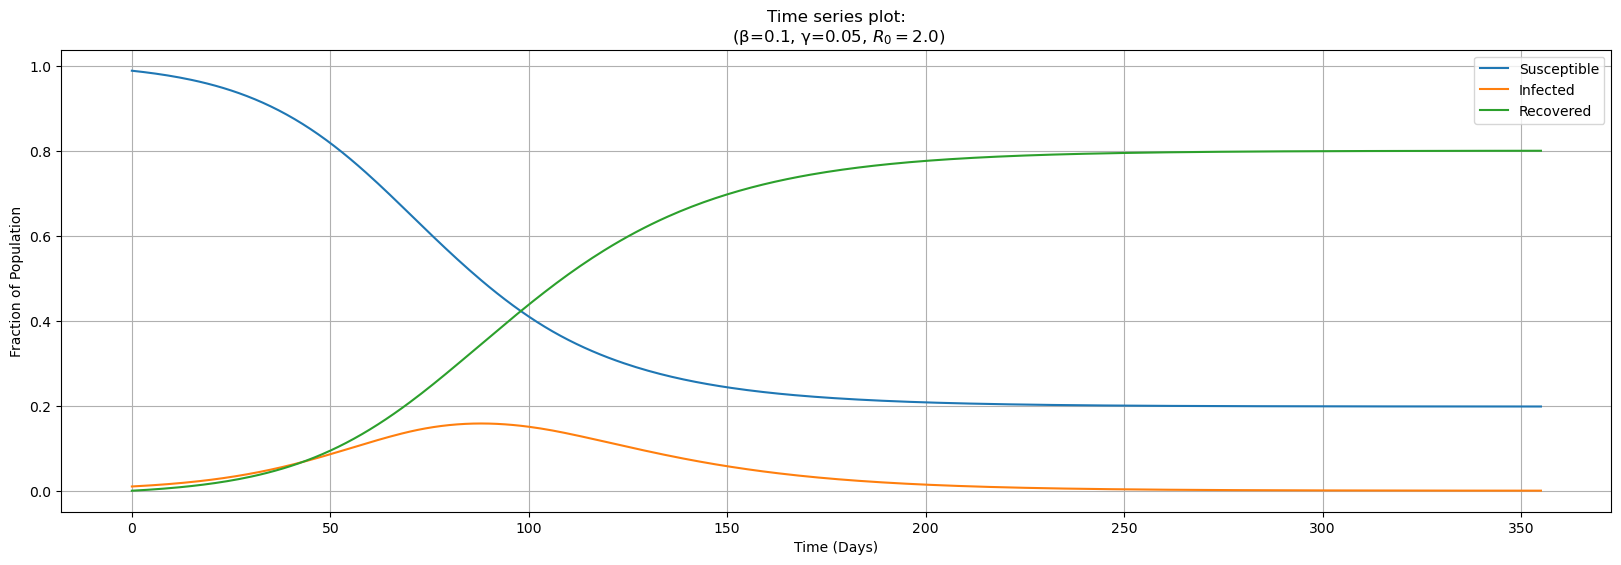

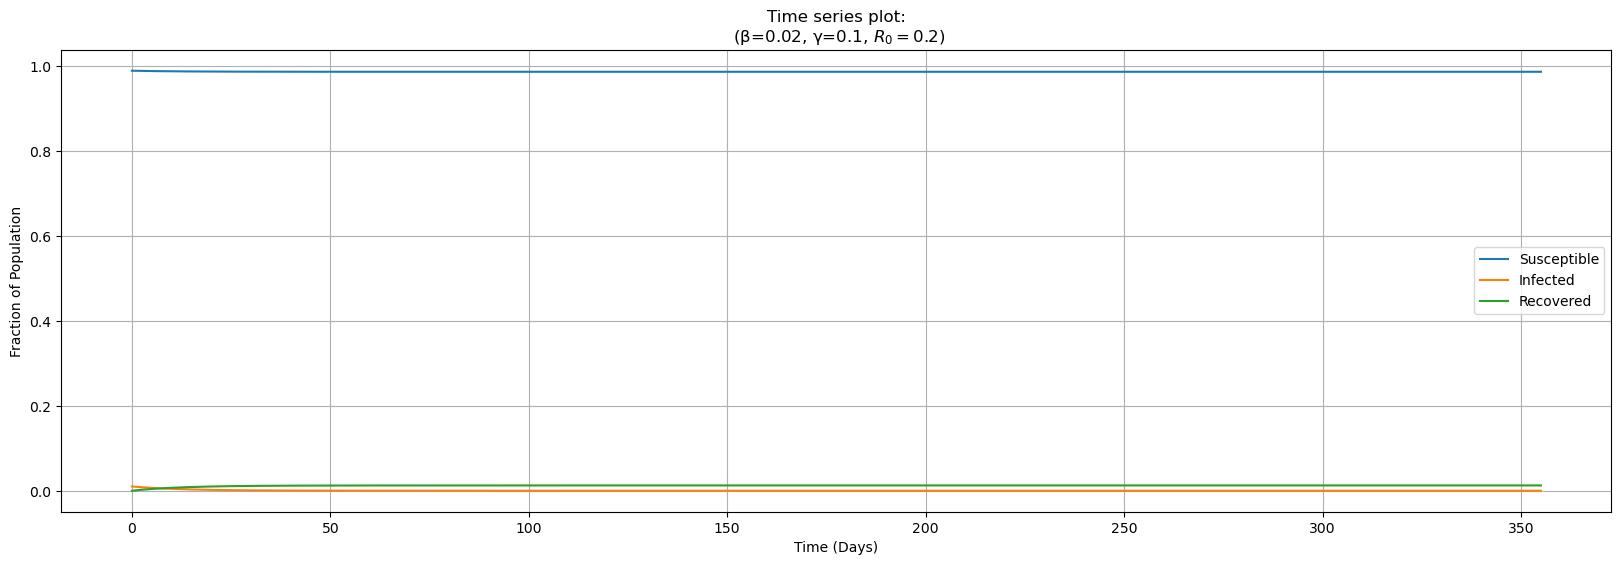

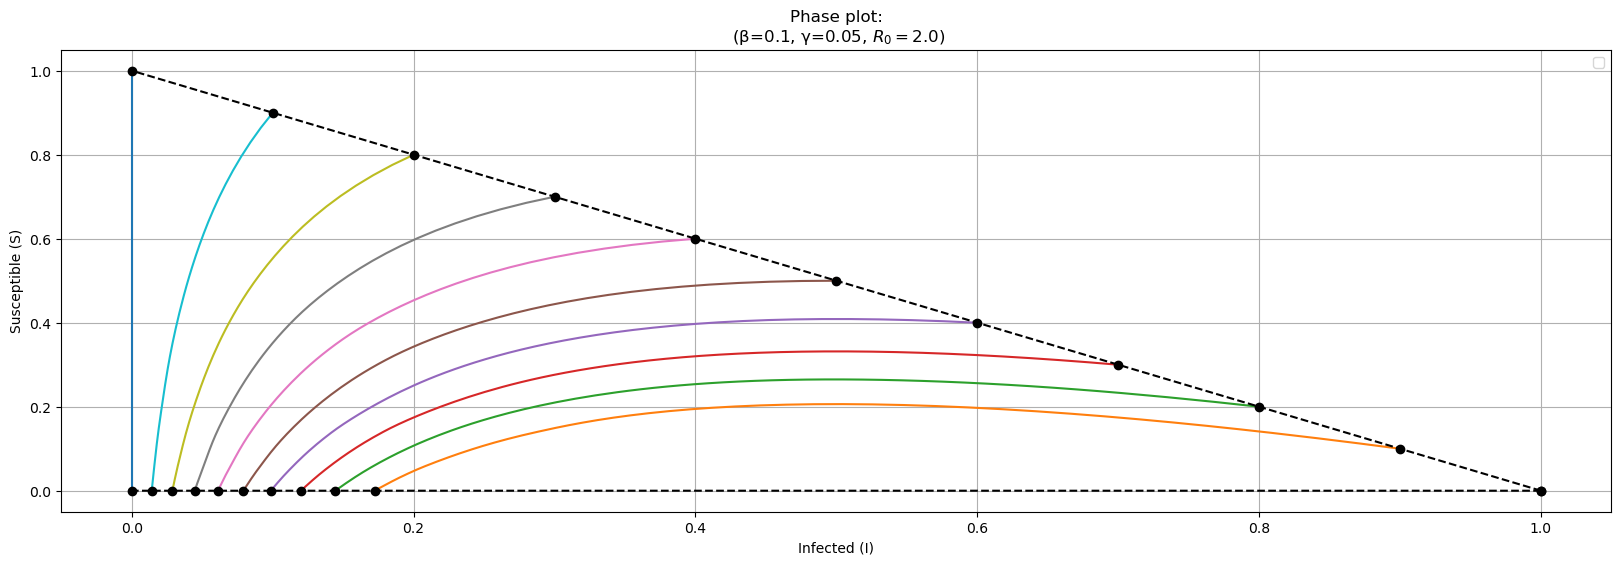

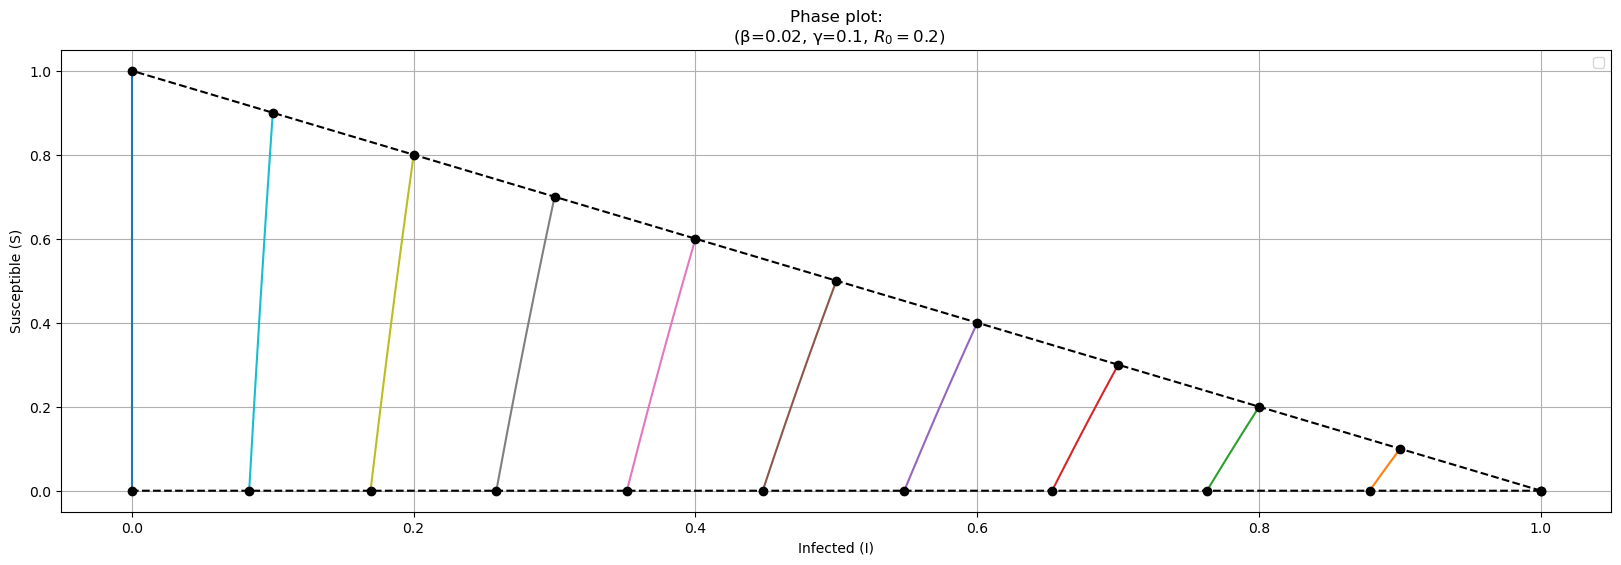

In [185]:
scenarios = {"epidemic":(0.1, 0.05), "no epidemic":(0.02, 0.1)}
y0 = {"S": 0.99, "I": 0.01, "R": 0}
t = 356

for parameters in scenarios.values():
    sir_model = SIR(y0, parameters, t)
    sir_data = sir_model.solve(sir_model.equations)

    fig, ax = sir_model.time_plot(sir_data, ["Susceptible", "Infected", "Recovered"], ["Time (Days)", "Fraction of Population"])
    R0 = sir_model.R0()
    ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
    fig.show()

for parameters in scenarios.values():
    sir_model = SIR(y0, parameters, t)
    sir_data = sir_model.solve(sir_model.equations)

    fig, ax = sir_model.phase_plot()
    R0 = sir_model.R0()
    ax.set_title(f"Phase plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
    fig.show()

The effect of different beta and gamma values on the $R_0$.
When $R_0 < 1 $ no epidemic can occur.

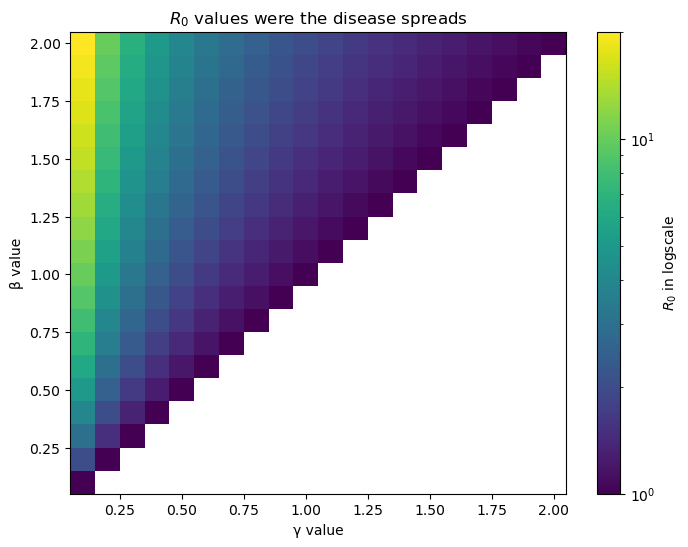

In [186]:
MAX_BETA = 2.1
MAX_GAMMA = 2.1
STEP_SIZE = 0.1

beta_values = np.arange(0.1, MAX_BETA, STEP_SIZE)
gamma_values = np.arange(0.1, MAX_GAMMA, STEP_SIZE)

R0_values = np.zeros((len(beta_values), len(gamma_values)))

for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        R0_values[i, j] = beta / gamma

masked_R0_values = np.ma.masked_where(R0_values < 1, R0_values)

fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(gamma_values, beta_values, masked_R0_values, shading='auto', cmap='viridis', norm=LogNorm(vmin=masked_R0_values.min(), vmax=masked_R0_values.max()))
ax.set_xlabel('γ value')
ax.set_ylabel('β value')
ax.set_title('$R_0$ values were the disease spreads')
fig.colorbar(c, ax=ax, label='$R_0$ in logscale')

plt.show()

## 1.2. Fit the parameters based on historical influenza outbreak within a boys school

In [187]:
target = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])
df = pd.DataFrame({
    'Number': target
})
print("Target:")
df.T

Target:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Number,1,3,8,28,75,221,291,255,235,190,125,70,28,12,5


In [188]:
N = 763
init_infected = 1
I0 = init_infected / N
R0 = 0.0
S0 = 1 - (I0 + R0)

y0 = {"S": S0, "I": I0, "R": R0}
t = 15

In [189]:
STEP_SIZE = 0.01
INFECTED = 1

beta_range = np.arange(0, MAX_BETA, STEP_SIZE)
gamma_range = np.arange(0, MAX_GAMMA, STEP_SIZE)

best_beta, best_gamma = 0.0, 0.0
lowest_error = float('inf')
error_matrix = np.zeros((len(beta_range), len(gamma_range)))

for i, beta in enumerate(beta_range):
    for j, gamma in enumerate(gamma_range):
        sir_model = SIR(y0, (beta, gamma), t)
        I_data = sir_model.solve(sir_model.equations)[INFECTED]

        error = mean_squared_error(I_data * N, target)
        error_matrix[i][j] = error
        if error < lowest_error:
            lowest_error = error
            best_beta, best_gamma = beta, gamma

print(f"Best parameters: β = {best_beta:.2f}, γ = {best_gamma:.2f}")
print(f"Lowest error: {lowest_error:.2f}")

Best parameters: β = 1.67, γ = 0.45
Lowest loss: 269.98


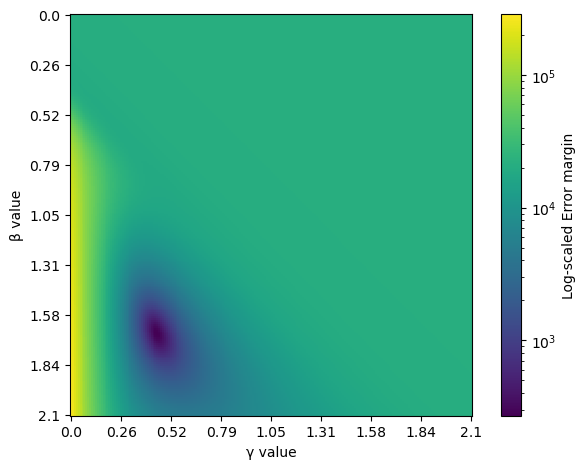

In [190]:
AXIS_POINTS = 9
plt.imshow(error_matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest')

x_ticks = np.linspace(0, error_matrix.shape[1]-1, AXIS_POINTS)
y_ticks = np.linspace(0, error_matrix.shape[0]-1, AXIS_POINTS)
plt.xticks(x_ticks, np.round(np.linspace(0, MAX_BETA, AXIS_POINTS), 2)) 
plt.yticks(y_ticks, np.round(np.linspace(0, MAX_GAMMA, AXIS_POINTS), 2)) 

plt.colorbar(label='Log-scaled Error margin')
plt.xlabel('γ value')
plt.ylabel('β value')
plt.tight_layout()
plt.show()

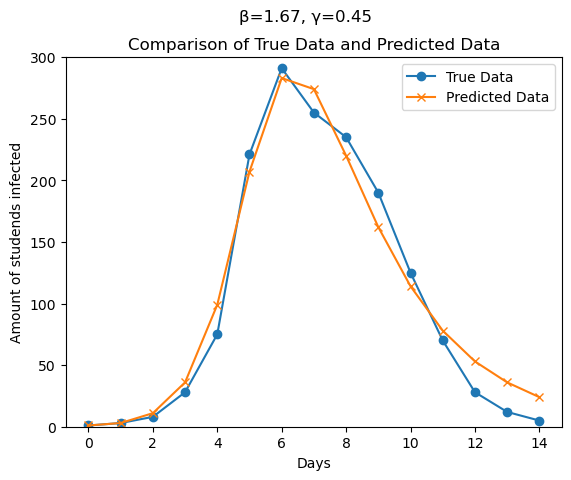

In [191]:
sir_model = SIR(y0, (best_beta, best_gamma), t)
I_data = sir_model.solve(sir_model.equations)[INFECTED]
I_data = np.round(I_data * N, 0).astype(int)

y_min = 0
y_max = 300

x = columns=np.arange(0, t + 1)
plt.plot(np.arange(0, t), target, marker='o', label='True Data')
plt.plot(np.arange(0, t), I_data, marker='x', label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Amount of studends infected')
plt.title('Comparison of True Data and Predicted Data')
plt.suptitle(f'β={best_beta}, γ={best_gamma}')
plt.ylim(y_min, y_max)
plt.legend()

In [192]:
target = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])
df = pd.DataFrame({
    'Target Number': target,
    'Predicted Number': I_data
})
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Target Number,1,3,8,28,75,221,291,255,235,190,125,70,28,12,5
Predicted Number,1,3,11,36,99,207,283,274,220,162,114,78,53,36,24


# 1.3 Think of possible vaccination strategies for the school case

In [ ]:
class SIRV(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta, gamma, v):
        S, I, R, V = init_y
        dSdt = -beta * S * I
        dIdt = beta * S * I - gamma * I
        dRdt = gamma * I
        dVdt = v * S
        return [dSdt, dIdt, dRdt, dVdt]

    def R0(self):
        # R_0 based on Turkyilmazoglu (2022).
        beta, gamma, v = self.parameters
        return round(beta + v / gamma, 2) if gamma != 0 else 0

### Vaccinating based on the amount of infected

/tmp/ipykernel_7285/3892049451.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(0.02, 0.1, 0.01)


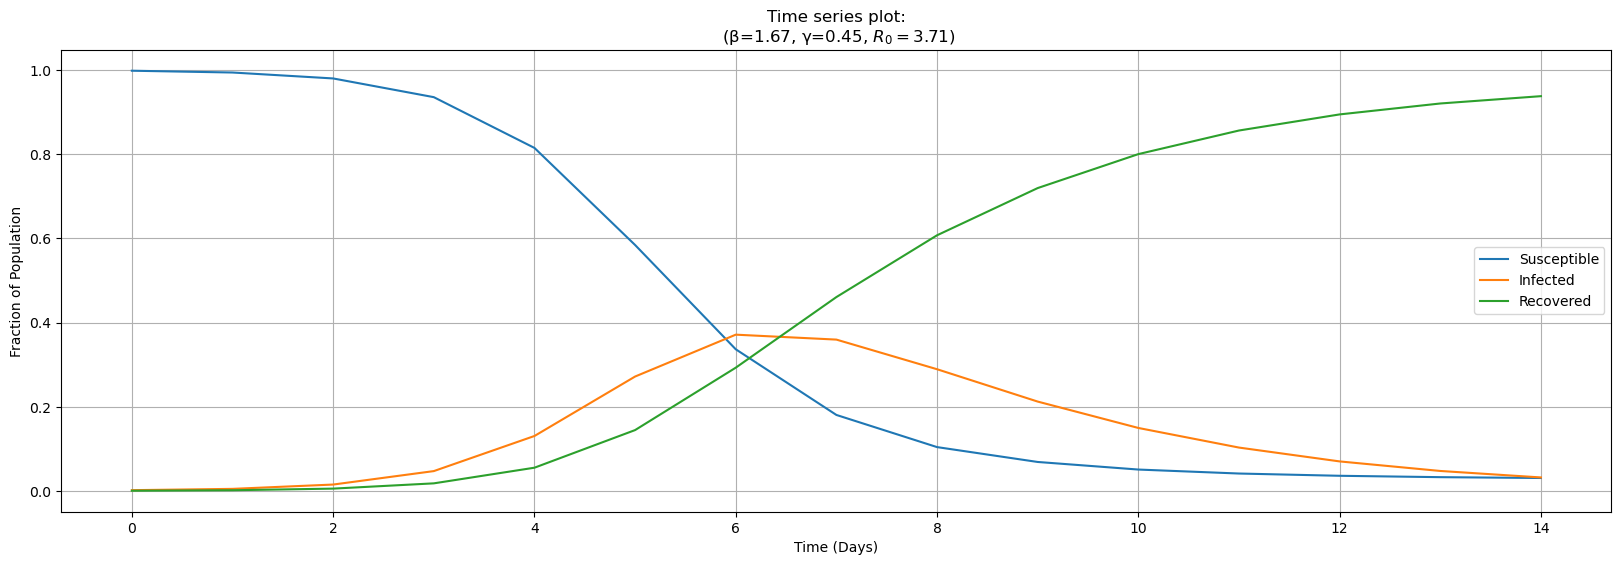

In [197]:
parameters = (best_beta, best_gamma)
sirv_model = SIR(y0, parameters, t)
sirv_data = sirv_model.solve(sirv_model.equations)

fig, ax = sirv_model.time_plot(sirv_data, ["Susceptible", "Infected", "Recovered"], ["Time (Days)", "Fraction of Population"])
R0 = sirv_model.R0()
ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
fig.show()

# vacc_rate = 0.01
# vacc_parameters = parameters + (vacc_rate, )

# sirv_model = SIR(y0, vacc_parameters, t)
# sirv_data = sirv_model.solve(sirv_model.equations)
# fig, ax = sirv_model.time_plot(sirv_data, ["Susceptible", "Infected", "Recovered"], ["Time (Days)", "Fraction of Population"])
# R0 = sirv_model.R0()
# ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, v={parameters[2]} $R_0={R0}$)")
# fig.show()